In [93]:
!pip install -q transformers 

^C
ERROR: Operation cancelled by user


In [94]:
!pip install -q evaluate jiwer

^C
ERROR: Operation cancelled by user


In [95]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from evaluate import load
from transformers import AdamW
from tqdm.notebook import tqdm
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, VisionEncoderDecoderConfig
import warnings
import wandb
import time

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [96]:
# Define the paths
dataset_dir = '/kaggle/input/captcha'
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

In [97]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, processor, max_target_length=10):
        self.root_dir = root_dir
        self.data = []
        self.processor = processor
        self.max_target_length = max_target_length
        
        for file_name in os.listdir(self.root_dir):
            self.data.append((os.path.join(root_dir, file_name), file_name.removesuffix('.png')))
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get file name + text 
        file_path, text = self.data[idx]
        
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [98]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = CaptchaDataset(root_dir=train_dir, processor=processor)
valid_dataset = CaptchaDataset(root_dir=valid_dir, processor=processor)
test_dataset = CaptchaDataset(root_dir=test_dir, processor=processor)

In [99]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 6839
Number of validation examples: 684
Number of testing examples: 683


In [100]:
encoding = test_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([10])


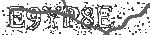

In [101]:
image = Image.open(os.path.join(test_dir, os.listdir(test_dir)[0])).convert("RGB")
image

In [103]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

e9yp8e


In [104]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [105]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [106]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 10
model.config.length_penalty = 0
model.config.early_stopping = True
model.config.num_beams = 2

In [107]:
cer_metric = load("cer")

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 150
best_valid_loss = float('inf')
wandb.login(key="")
wandb.init(project='captcha',
                   resume='allow',
                   config={'num_epochs': num_epochs})
wandb.watch(model)

In [ ]:
for epoch in range(num_epochs):
    # ------------------- TRAIN -------------------
    start = time.time()
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # get the inputs and move to device
        for k, v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    end = time.time()
    train_loss /= len(train_dataloader)
    
    # ------------------- VALID -------------------
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_loss += cer

    valid_loss /= len(valid_dataloader)
    
    # ------------------- LOG -------------------
    wandb.log({
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'learning_rate': optimizer.param_groups[0]['lr']
    })
    
    # ------------------- VERBOSE -------------------
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation CER: {valid_loss:.4f} | Time: {end-start:.2f}s')

    # ------------------- CHECKPOINT -------------------
    model.save_pretrained("OCR-model/latest")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model.save_pretrained("OCR-model/best")
        print("New best checkpoint saved!")
        
wandb.finish()

In [111]:
# loading model and config from pretrained folder
encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/input/captcha-ckp/OCR-model/best")
OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/captcha-ckp/OCR-model/best", config=encoder_decoder_config).to(device)
# encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/working/OCR-model/best")
# OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/OCR-model/best", config=encoder_decoder_config).to(device)

In [124]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(train_dataset, batch_size=16)):
        # run batch generation
        outputs = OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 


  0%|          | 0/428 [00:00<?, ?it/s]

In [125]:
testnames = [f for f in os.listdir(train_dir) if f.endswith('.png')]
ground_truths = [filename.removesuffix('.png') for filename in testnames]

correct = 0
for generated, ground_truth in zip(generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1

accuracy = correct / len(ground_truths) * 100
print(f"Train accuracy: {accuracy:.2f}%")

Train accuracy: 99.62%


In [114]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=16)):
        # run batch generation
        outputs = OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 


  0%|          | 0/43 [00:00<?, ?it/s]

In [115]:
testnames = [f for f in os.listdir(test_dir) if f.endswith('.png')]
ground_truths = [filename.removesuffix('.png') for filename in testnames]

correct = 0
for generated, ground_truth in zip(generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1

accuracy = correct / len(ground_truths) * 100
print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 84.63%


In [116]:
def random_infer():
    # Get a random image path from the test folder
    image_files = [f for f in os.listdir('/kaggle/input/captcha/train') if f.endswith('.png')]
    random_image_file = random.choice(image_files)
    print("File name: " + random_image_file)
    
    image_path = os.path.join('/kaggle/input/captcha/train', random_image_file)
    image = Image.open(image_path)
    plt.imshow(image)

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    #print(f"Pixel values shape: {pixel_values.shape}")

    # Generate text from the image
    generated_ids = OCR_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"Generated text: {generated_text}")

    return generated_text

File name: l3pz3sp.png
Generated text: l3pz3sp


'l3pz3sp'

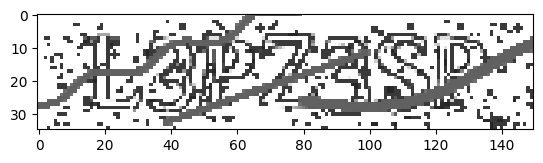

In [119]:
random_infer()